# Useful links

- For better choosing which model to use, check out the [Scikit cheat sheet](https://scikit-learn.org/1.5/machine_learning_map.html).
- [Blog post about multinomial Logistic Regression with Python](https://machinelearningmastery.com/multinomial-logistic-regression-with-python/).

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Exploratory Data Analysis

- Use df.info and df.describe;
- Do a pairplot of every column;
- Do a displot of what you're trying to predict;
- Do a heatmap of the correlation matrix;
- Get the columns with the most correlation (below);
  - Then explore the highest correlation features w scatter plots.

In [31]:
dfhouses = pd.read_csv('data/kc_house_data.csv')

In [33]:
dfhouses.head(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062


In [35]:
dfhouses.drop(columns=['date'], axis=1).corr()['price'].sort_values()

zipcode         -0.053402
id              -0.016772
long             0.022036
condition        0.036056
yr_built         0.053953
sqft_lot15       0.082845
sqft_lot         0.089876
yr_renovated     0.126424
floors           0.256804
waterfront       0.266398
lat              0.306692
bedrooms         0.308787
sqft_basement    0.323799
view             0.397370
bathrooms        0.525906
sqft_living15    0.585241
sqft_above       0.605368
grade            0.667951
sqft_living      0.701917
price            1.000000
Name: price, dtype: float64

# Feature Engineering

## Dealing with Dates

In [37]:
dfhouses['date']

0        10/13/2014
1         12/9/2014
2         2/25/2015
3         12/9/2014
4         2/18/2015
            ...    
21592     5/21/2014
21593     2/23/2015
21594     6/23/2014
21595     1/16/2015
21596    10/15/2014
Name: date, Length: 21597, dtype: object

In [39]:
df['date'] = pd.to_datetime(df['date'])
df['date']

0       2014-10-13
1       2014-12-09
2       2015-02-25
3       2014-12-09
4       2015-02-18
           ...    
21592   2014-05-21
21593   2015-02-23
21594   2014-06-23
21595   2015-01-16
21596   2014-10-15
Name: date, Length: 21597, dtype: datetime64[ns]

- By converting it to a datetime type, we can easily get properties such as month and year.

In [42]:
df['month'] = df['date'].apply(lambda date:date.month)
df['year'] = df['date'].apply(lambda date:date.year)
df.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,year
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,0,1955,0,98178,47.5112,-122.257,1340,5650,10,2014
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,400,1951,1991,98125,47.7210,-122.319,1690,7639,12,2014


## Dealing with Missing Data
- For dealing with missing data, we normally either drop the rows or fill the values with something else;
- The process of filling missing data is called [imputation](https://en.wikipedia.org/wiki/Imputation_(statistics)).

### Counting and Visualizing Missing Data

In [5]:
train = pd.read_csv('data/titanic_train.csv')

- To quickly count missing data, use this trick:

In [7]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

- A heatmap can also be very useful for visualizing this:

<Axes: >

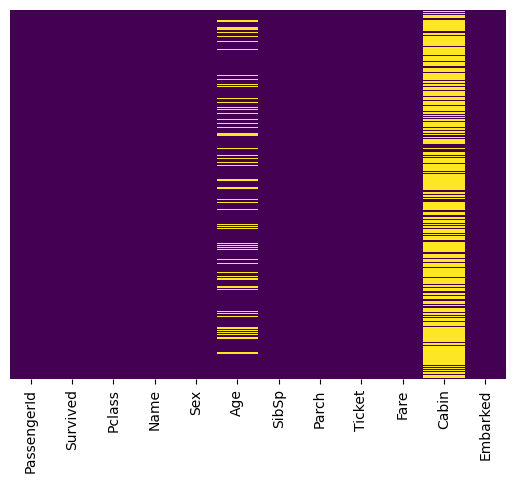

In [9]:
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

### Imputation

- [Imputation](https://en.wikipedia.org/wiki/Imputation_(statistics)) is the process of filling missing data with substituted values;
- We do this because missing data create 3 common problems:
  - Introduces a substantial amount of bias;
  - Makes the handling and analysis of the data more arduous;
  - Creates reductions in efficiency.
- We'll use the same Titanic Dataset from above.
- The column 'Age' has only a few missing values. We will use imputation to deal with this.

- There's several ways we could do this:
1) Fill all missing values with the average of the rest of the values;
2) Fill missing values with the average based on the passenger class;
3) Construct a linear regression ML model to predict the ages of the missing data.

- For simplicity, we'll go with number 2.

In [11]:
means = train[['Age', 'Pclass']].groupby('Pclass').mean()

def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    if pd.isnull(Age):
        return means.loc[Pclass].item()
    return Age

print(impute_age((np.NaN,2)))
print(impute_age((33,2)))

29.87763005780347
33


In [12]:
train['Age'] = train['Age'].fillna(value=train[['Age', 'Pclass']].apply(impute_age, axis=1))

C:\Users\pedro\AppData\Local\Temp\ipykernel_5688\2868642157.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Age = cols[0]
C:\Users\pedro\AppData\Local\Temp\ipykernel_5688\2868642157.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Pclass = cols[1]


- With that, empty values on the 'Age' column have been filled with the averages based on passenger class.

### Dropping Missing Data
- Let's see how many empty values are left now.

In [15]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

- Cabin has way too many empty values to be useful. So we'll simply drop that column.

In [17]:
train.drop('Cabin', axis=1, inplace=True)

- There should be only a few missing values left. For those, we'll simply drop the rows.

In [19]:
train.shape[0]

891

In [20]:
train.dropna(inplace=True)
train.shape[0]

889

## Converting Categorical Features
- Sometimes we'll need to convert all categorical features to binary columns;
- This is specially true at Logistic Regression models, because they have binary classifiers;
- We do that with `get_dummies`.

In [23]:
pd.get_dummies(train['Sex']).head()

,female,male
0,False,True
1,True,False
2,True,False
3,True,False
4,False,True


- Above: We cannot feed both columns into the ML model, because one is a perfect predictor of the other (Multi-colinearity).
- We need to pass the 'drop_first' argument:

In [25]:
sex = pd.get_dummies(train['Sex'], drop_first=True)
sex.head()

,male
0,True
1,False
2,False
3,False
4,True


- For classes with `n` unique values, we'll generate `n - 1` columns:

In [27]:
embark = pd.get_dummies(train['Embarked'], drop_first=True)
embark.head()

,Q,S
0,False,True
1,False,False
2,False,True
3,False,True
4,False,True


- These columns can then be concatened into the dataset.

In [29]:
train = pd.concat([train, sex, embark], axis=1)
train.drop(['PassengerId','Sex','Embarked','Name','Ticket'],axis=1, inplace=True)
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,True,False,True
1,1,1,38.0,1,0,71.2833,False,False,False
2,1,3,26.0,0,0,7.9250,False,False,True
3,1,1,35.0,1,0,53.1000,False,False,True
4,0,3,35.0,0,0,8.0500,True,False,True


## Scaling
- Sometimes the data on some columns must be scaled for better performance;
- This is specially true on algorithms that rely on distance of different rows, like KNN;
- If you want to fit and transform in one step, all scalers have a `fit_transform` function!

### StandardScaler
- Useful on Algorithms like KNN.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [31]:
df = pd.read_csv('data/Classified Data', index_col=0)
df.head()

,WTT,PTI,EQW,SBI,LQE,QWG,FDJ,PJF,HQE,NXJ,TARGET CLASS
0,0.913917,1.162073,0.567946,0.755464,0.780862,0.352608,0.759697,0.643798,0.879422,1.231409,1
1,0.635632,1.003722,0.535342,0.825645,0.924109,0.648450,0.675334,1.013546,0.621552,1.492702,0
2,0.721360,1.201493,0.921990,0.855595,1.526629,0.720781,1.626351,1.154483,0.957877,1.285597,0
3,1.234204,1.386726,0.653046,0.825624,1.142504,0.875128,1.409708,1.380003,1.522692,1.153093,1
4,1.279491,0.949750,0.627280,0.668976,1.232537,0.703727,1.115596,0.646691,1.463812,1.419167,1


In [32]:
scaler = StandardScaler()

scaler.fit(df.drop('TARGET CLASS', axis=1))

scaled_features = scaler.transform(df.drop('TARGET CLASS', axis=1)) # Performs a standartization by centering and scaling

df_feat = pd.DataFrame(scaled_features, columns= df.columns[:-1])
df_feat.head()

,WTT,PTI,EQW,SBI,LQE,QWG,FDJ,PJF,HQE,NXJ
0,-0.123542,0.185907,-0.913431,0.319629,-1.033637,-2.308375,-0.798951,-1.482368,-0.949719,-0.643314
1,-1.084836,-0.430348,-1.025313,0.625388,-0.444847,-1.152706,-1.129797,-0.202240,-1.828051,0.636759
2,-0.788702,0.339318,0.301511,0.755873,2.031693,-0.870156,2.599818,0.285707,-0.682494,-0.377850
3,0.982841,1.060193,-0.621399,0.625299,0.452820,-0.267220,1.750208,1.066491,1.241325,-1.026987
4,1.139275,-0.640392,-0.709819,-0.057175,0.822886,-0.936773,0.596782,-1.472352,1.040772,0.276510


### MinMax Scaler
- Useful on TensorFlow.

### Note about Scaling on Split Data

- You should always scale the training set and test sets separately to avoid **DATA LEAKAGE**;
  - You should fit and transform on the Train split, but only Transform the test split (We don't want to assume we have prior information of the test set):

In [55]:
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=101)

# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Evaluating Models Visually
- Outside of metrics, there are a couple of ways to make sure the models have been properly fitted;

## Linear Regression Models

### Scatterplot
- A quick way to visualize the model performance is doing a Scatter plot of the predictions and the test values;
- If it's similar to a line, the model fits well.

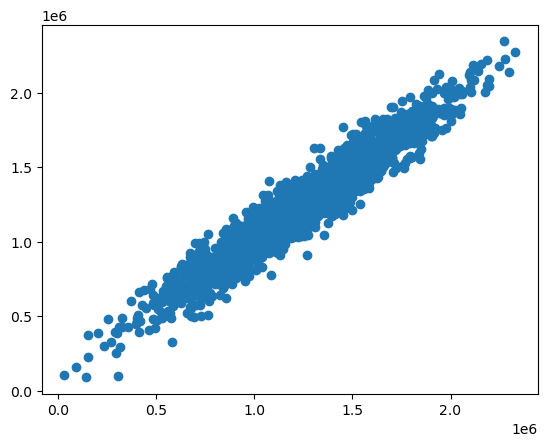

In [36]:
df = pd.read_csv('data/USA_Housing.csv')

X = df[['Avg. Area Income', 'Avg. Area House Age', 'Avg. Area Number of Rooms', 'Avg. Area Number of Bedrooms', 'Area Population']]
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

lm = LinearRegression()

lm.fit(X_train, y_train)

predictions = lm.predict(X_test)

plt.scatter(y_test, predictions)

### Displot of Residuals
- On a good linear fit, the residuals are normally distributed.

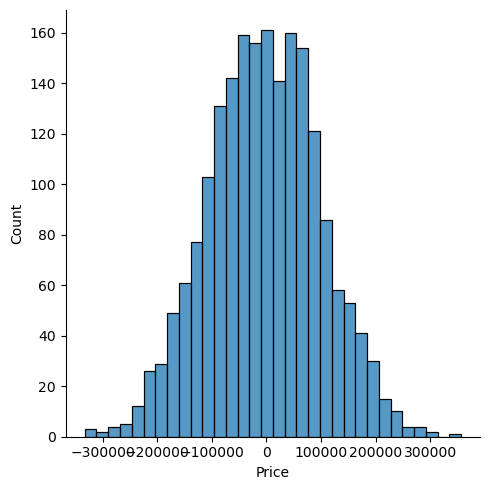

In [38]:
sns.displot((y_test - predictions))

# Hyperparameter Tuning

## Elbow Method
- The Elbow Method is a visual approach used to determine the ideal 'K' in some algorithms;
- Useful for KNN and K-Means Clustering.

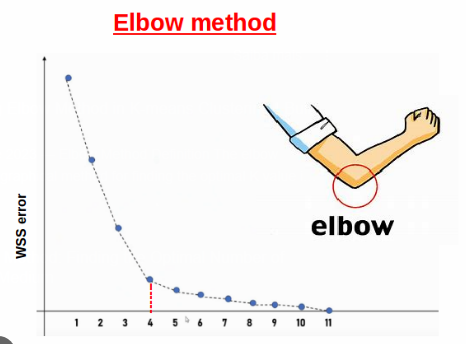

### With KNN
- We train classifiers with multiple values of K and choosing the one with an acceptable error (and isn't too high, to save on computations).

Text(0, 0.5, 'Error rate')

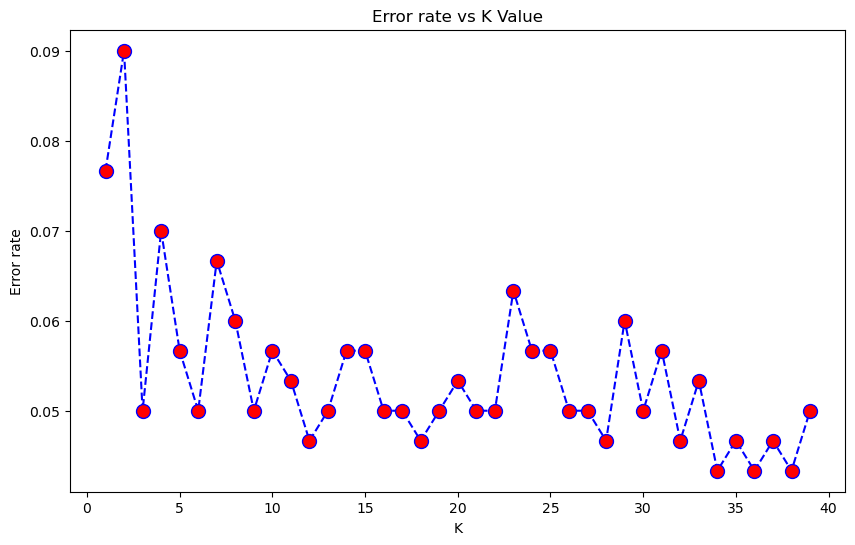

In [42]:
df = pd.read_csv('data/Classified Data', index_col=0)

X = df_feat
y = df['TARGET CLASS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

error_rate = []

for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors= i)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    error_rate.append(np.mean(pred != y_test)) 

plt.figure(figsize=(10,6))
plt.plot(range(1,40), error_rate, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error rate vs K Value')
plt.xlabel('K')
plt.ylabel('Error rate')

- Based on this graph, 18 seems to be a good choice.

In [44]:
knn = KNeighborsClassifier(n_neighbors= 18)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       159
           1       0.97      0.93      0.95       141

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



## With K-Means Clustering

## GridSearch
- Easily try on multiple values of hyperparameters;
- GridSearchCV is a meta-estimator. Takes one estimator and creates a new one that behaves the same;
- Below is an example with the Support Vector Machine Classifier.

In [47]:
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC

cancer = load_breast_cancer()

df_feat = pd.DataFrame(cancer['data'], columns=cancer['feature_names'])

X = df_feat
y = cancer['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

- First, runs the same loop with cross-validation to find the best parameter combination
- Once it has the best parameter combination, it runs fit again on the data without cross-validation.
- So it builds a SINGLE new model with the best parameter settings.

In [49]:
from sklearn.model_selection import GridSearchCV

# keys: parameters
# values: list of settings to be tested
param_grid = {'C':[0.1,1,10,100,100], 'gamma':[1,0.1,0.01,0.001,0.0001]}

grid = GridSearchCV(SVC(), param_grid, verbose=3) #Higher the number of verbose, the more text output.

grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ....................C=0.1, gamma=1;, score=0.637 total time=   0.0s
[CV 2/5] END ....................C=0.1, gamma=1;, score=0.637 total time=   0.0s
[CV 3/5] END ....................C=0.1, gamma=1;, score=0.625 total time=   0.0s
[CV 4/5] END ....................C=0.1, gamma=1;, score=0.633 total time=   0.0s
[CV 5/5] END ....................C=0.1, gamma=1;, score=0.633 total time=   0.0s
[CV 1/5] END ..................C=0.1, gamma=0.1;, score=0.637 total time=   0.0s
[CV 2/5] END ..................C=0.1, gamma=0.1;, score=0.637 total time=   0.0s
[CV 3/5] END ..................C=0.1, gamma=0.1;, score=0.625 total time=   0.0s
[CV 4/5] END ..................C=0.1, gamma=0.1;, score=0.633 total time=   0.0s
[CV 5/5] END ..................C=0.1, gamma=0.1;, score=0.633 total time=   0.0s
[CV 1/5] END .................C=0.1, gamma=0.01;, score=0.637 total time=   0.0s
[CV 2/5] END .................C=0.1, gamma=0.01

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 100],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001]},
             verbose=3)

- The best values are stored on these variables:

In [51]:
grid.best_params_

{'C': 1, 'gamma': 0.0001}

In [52]:
grid.best_estimator_

SVC(C=1, gamma=0.0001)

- Then you can generate predictions directly from the model. It is already fit to the data.

In [54]:
grid_predictions = grid.predict(X_test)

print(confusion_matrix(y_test, grid_predictions))
print('\n')
print(classification_report(y_test, grid_predictions))

[[ 59   7]
 [  4 101]]


              precision    recall  f1-score   support

           0       0.94      0.89      0.91        66
           1       0.94      0.96      0.95       105

    accuracy                           0.94       171
   macro avg       0.94      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171



# Neural Networks

## Choosing Activation and Loss Functions

Keep in mind what kind of problem you are trying to solve.

- Multi-class Classification
  - Output Layer: `model.add(Dense(units=1))`
  - Compilation: `model.compile(loss='categorical_crossentropy', metrics=['accuracy'])`
- Binary Classification
  - Output Layer: `model.add(Dense(units=1, activation='sigmoid'))`
  - Compilation: `model.compile(loss='binary_crossentropy', metrics=['accuracy'])`
- Regression
  - Output Layer: `model.add(Dense(1))`
  - Compilation: `model.compile(loss='mse')`

Note: Optimizer can be whatever, metrics can vary.

## Choosing the number of Layers
- https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

"In sum, for most problems, one could probably get decent performance (even without a second optimization step) by setting the hidden layer configuration using just two rules: (i) the number of hidden layers equals one; and (ii) the number of neurons in that layer is the mean of the neurons in the input and output layers."

## Dealing with Overfitting
### Early stopping
- Keras automatically stops training based on a loss condition on the validation data.

### Dropout Layers
- Layers added to turnoff neurons during training to prevent overfitting.

# Datasets to play with
## Collections of Datasets
- [UCI Dataset Collection](https://archive.ics.uci.edu/);

## Recommender Systems
**Movies Recommendation:**

- MovieLens - Movie Recommendation Data Sets http://www.grouplens.org/node/73
- Yahoo! - Movie, Music, and Images Ratings Data Sets http://webscope.sandbox.yahoo.com/catalog.php?datatype=r
- Jester - Movie Ratings Data Sets (Collaborative Filtering Dataset) http://www.ieor.berkeley.edu/~goldberg/jester-data/
- Cornell University - Movie-review data for use in sentiment-analysis experiments http://www.cs.cornell.edu/people/pabo/movie-review-data/

**Music Recommendation:**

- Last.fm - Music Recommendation Data Sets http://www.dtic.upf.edu/~ocelma/MusicRecommendationDataset/index.html
- Yahoo! - Movie, Music, and Images Ratings Data Sets http://webscope.sandbox.yahoo.com/catalog.php?datatype=r
- Audioscrobbler - Music Recommendation Data Sets http://www-etud.iro.umontreal.ca/~bergstrj/audioscrobbler_data.html
- Amazon - Audio CD recommendations http://131.193.40.52/data/

**Books Recommendation:**

- Institut für Informatik, Universität Freiburg - Book Ratings Data Sets http://www.informatik.uni-freiburg.de/~cziegler/BX/
Food Recommendation:

- Chicago Entree - Food Ratings Data Sets http://archive.ics.uci.edu/ml/datasets/Entree+Chicago+Recommendation+Data
Merchandise Recommendation:

**Healthcare Recommendation:**

- Nursing Home - Provider Ratings Data Set http://data.medicare.gov/dataset/Nursing-Home-Compare-Provider-Ratings/mufm-vy8d
- Hospital Ratings - Survey of Patients Hospital Experiences http://data.medicare.gov/dataset/Survey-of-Patients-Hospital-Experiences-HCAHPS-/rj76-22dk

**Dating Recommendation:**

- www.libimseti.cz - Dating website recommendation (collaborative filtering) http://www.occamslab.com/petricek/data/
- National University of Singapore - Scholarly Paper Recommendation http://www.comp.nus.edu.sg/~sugiyama/SchPaperRecData.html